# 10. 分析句子的意思

我们已经看到利用计算机的能力来处理大规模文本是多么有用。现在我们已经有了分析器和基于特征的语法，我们能否做一些类似分析句子的意思这样有用的事情？本章的目的是要回答下列问题：

1. 我们如何能表示自然语言的意思，使计算机能够处理这些表示？
2. 我们怎样才能将意思表示与无限的句子集合关联？
3. 我们怎样才能使用程序来连接句子的意思表示到知识的存储？

一路上，我们将学习一些逻辑语义领域的形式化技术，看看如何用它们来查询存储了世间真知的数据库。

<a href="#1-自然语言理解">1 自然语言理解</a>

<a href="#3-一阶逻辑">3 一阶逻辑</a>

<a href="#4-英语句子的语义">4 英语句子的语义</a>

<a href="#5-段落语义层">5 段落语义层</a>

<a href="#6-小结">6 小结</a>

<a href="#7-深入阅读">7 深入阅读</a>

<a href="#8-练习">8 练习</a>

## 1 自然语言理解

## 1.1 查询数据库

假设有一个程序，让我们输入一个自然语言问题，返回给我们正确的答案：

In [1]:
import nltk
nltk.data.show_cfg('grammars/book_grammars/sql0.fcfg')

% start S
S[SEM=(?np + WHERE + ?vp)] -> NP[SEM=?np] VP[SEM=?vp]
VP[SEM=(?v + ?pp)] -> IV[SEM=?v] PP[SEM=?pp]
VP[SEM=(?v + ?ap)] -> IV[SEM=?v] AP[SEM=?ap]
NP[SEM=(?det + ?n)] -> Det[SEM=?det] N[SEM=?n]
PP[SEM=(?p + ?np)] -> P[SEM=?p] NP[SEM=?np]
AP[SEM=?pp] -> A[SEM=?a] PP[SEM=?pp]
NP[SEM='Country="greece"'] -> 'Greece'
NP[SEM='Country="china"'] -> 'China'
Det[SEM='SELECT'] -> 'Which' | 'What'
N[SEM='City FROM city_table'] -> 'cities'
IV[SEM=''] -> 'are'
A[SEM=''] -> 'located'
P[SEM=''] -> 'in'


这使我们能够分析SQL查询：

In [2]:
from nltk import load_parser
cp = load_parser('grammars/book_grammars/sql0.fcfg')
query = 'What cities are located in China'
trees = list(cp.parse(query.split()))
answer = trees[0].label()['SEM']
answer = [s for s in answer if s]
q = ' '.join(answer)
print(q)

SELECT City FROM city_table WHERE Country="china"


注意

**轮到你来：**设置跟踪为最大，运行分析器，即`cp = load_parser('grammars/book_grammars/sql0.fcfg', trace=3)`，研究当边被完整的加入到图表中时，如何建立`sem`的值。

最后，我们在数据库`city.db`上执行查询，检索出一些结果：

In [3]:
from nltk.sem import chat80
rows = chat80.sql_query('corpora/city_database/city.db', q)
for r in rows: print(r[0], end=" ") 

canton chungking dairen harbin kowloon mukden peking shanghai sian tientsin 

由于每行`r`是一个单元素的元组，我们输出元组的成员，而不是元组本身 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#tuple-val)。

总结一下，我们已经定义了一个任务：计算机对自然语言查询做出反应，返回有用的数据。我们通过将英语的一个小的子集翻译成SQL来实现这个任务们可以说，我们的NLTK代码已经“理解”SQL，只要Python 能够对数据库执行SQL 查询，通过扩展，它也“理解”如What cities are located in China这样的查询。这相当于自然语言理解的例子能够从荷兰语翻译成英语。假设你是一个英语为母语的人，已经开始学习荷兰语。你的老师问你是否理解[(3)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-sem1)的意思：

In [4]:
nltk.boolean_ops()

negation       	-
conjunction    	&
disjunction    	|
implication    	->
equivalence    	<->


从命题符号和布尔运算符，我们可以建立命题逻辑的规范公式（或简称公式）的无限集合。首先，每个命题字母是一个公式。然后，如果φ是一个公式，那么`-`φ也是一个公式。如果φ和ψ是公式，那么`(`φ `&` ψ`)` `(`φ `|` ψ`)` `(`φ `->` ψ`)` `(`φ `<->` ψ`)`也是公式。

[2.1](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#tab-boolean-tcs)指定了包含这些运算符的公式为真的条件。和以前一样，我们使用φ和ψ作为句子中的变量，iff作为if and only if（当且仅当）的缩写。

表 2.1：

命题逻辑的布尔运算符的真值条件。

In [4]:
read_expr = nltk.sem.Expression.fromstring
read_expr('-(P & Q)')

<NegatedExpression -(P & Q)>

In [6]:
read_expr('P & Q')

<AndExpression (P & Q)>

In [7]:
read_expr('P | (R -> Q)')

<OrExpression (P | (R -> Q))>

In [8]:
read_expr('P <-> -- P')

<IffExpression (P <-> --P)>

从计算的角度来看，逻辑给了我们进行推理的一个重要工具。假设你表达Freedonia is not to the north of Sylvania，而你给出理由Sylvania is to the north of Freedonia。在这种情况下，你已经给出了一个论证。句子Sylvania is to the north of Freedonia是论证的假设，而Freedonia is not to the north of Sylvania是结论。从假设一步一步推到结论，被称为推理。通俗地说，就是我们以在结论前面写therefore这样的格式写一个论证。

In [7]:
lp = nltk.sem.Expression.fromstring
SnF = read_expr('SnF')
NotFnS = read_expr('-FnS')
R = read_expr('SnF -> -FnS')
prover = nltk.Prover9()
prover.config_prover9(r'D:/Prover9-Mace4/bin-win32')
# 下载 ./asset/Prover9-Mace4.zip 并解压
# 或者使用 ./asset/Prover9-Mace4-v05-setup.exe 安装
# 可直接指定代码所示路径，或设置为环境变量(可能无效)，不支持中文路径
prover.prove(NotFnS, [SnF, R])

True

这里有另一种方式可以看到结论如何得出。`SnF -> -FnS`在语义上等价于`-SnF | -FnS`，其中 "`|`"是对应于or的二元运算符。在一般情况下，φ`|`ψ在条件*s*中为真，要么φ在*s*中为真，要么ψ在*s*中为真。现在，假设`SnF`和`-SnF | -FnS`都在*s*中为真。如果`SnF`为真，那么`-SnF`不可能也为真；经典逻辑的一个基本假设是：一个句子在一种情况下不能同时为真和为假。因此，`-FnS`必须为真。

回想一下，我们解释相对于一个模型的一种逻辑语言的句子，它们是这个世界的一个非常简化的版本。一个命题逻辑的模型需要为每个可能的公式分配值`True`或`False`。我们一步步的来做这个：首先，为每个命题符号分配一个值，然后确定布尔运算符的含义（即[2.1](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#tab-boolean-tcs)）和运用它们到这些公式的组件的值，来计算复杂的公式的值。`估值`是从逻辑的基本符号映射到它们的值。下面是一个例子：

In [10]:
val = nltk.Valuation([('P', True), ('Q', True), ('R', False)])

我们使用一个配对的链表初始化一个`估值`，每个配对由一个语义符号和一个语义值组成。所产生的对象基本上只是一个字典，映射逻辑符号（作为字符串处理）为适当的值。

In [11]:
val['P']

True

正如我们稍后将看到的，我们的模型需要稍微更加复杂些，以便处理将在下一节中讨论的更复杂的逻辑形式；暂时的，在下面的声明中先忽略参数`dom`和`g`。

In [12]:
dom = set()
g = nltk.Assignment(dom)

现在，让我们用`val`初始化模型`m`：

In [13]:
m = nltk.Model(dom, val)

每一个模型都有一个`evaluate()`方法，可以确定逻辑表达式，如命题逻辑的公式，的语义值；当然，这些值取决于最初我们分配给命题符号如`P`，`Q`和`R`的真值。

In [14]:
print(m.evaluate('(P & Q)', g))

True


In [15]:
print(m.evaluate('-(P & Q)', g))

False


In [16]:
print(m.evaluate('(P & R)', g))

False


In [17]:
print(m.evaluate('(P | R)', g))

True


注意

**轮到你来：**做实验为不同的命题逻辑公式估值。模型是否给出你所期望的值？

到目前为止，我们已经将我们的英文句子翻译成命题逻辑。因为我们只限于用字母如`P`和`Q`表示原子句子，不能深入其内部结构。实际上，我们说将原子句子分成主语、宾语和谓词并没有语义上的好处。然而，这似乎是错误的：如果我们想形式化如[(9)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-proplog8)这样的论证，就必须要能“看到里面”基本的句子。因此，我们将超越命题逻辑到一个更有表现力的东西，也就是一阶逻辑。这正是我们下一节要讲的。

## 3 一阶逻辑

本章的剩余部分，我们将通过翻译自然语言表达式为一阶逻辑来表示它们的意思。并不是所有的自然语言语义都可以用一阶逻辑表示。但它是计算语义的一个不错的选择，因为它具有足够的表现力来表达语义的很多方面，而且另一方面，有出色的现成系统可用于开展一阶逻辑自动推理。

下一步我们将描述如何构造一阶逻辑公式，然后是这样的公式如何用来评估模型。

<a href="#3.1-句法">3.1 句法</a>

<a href="#3.2-一阶定理证明">3.2 一阶定理证明</a>

<a href="#3.3-一阶逻辑语言总结">3.3 一阶逻辑语言总结</a>

<a href="#3.5-独立变星和赋值">3.5 独立变星和赋值</a>

<a href="#3.6-量化">3.6 量化</a>

<a href="#3.7-量词范围歧义">3.7 量词范围歧义</a>

<a href="#3.8-模型的建立">3.8 模型的建立</a>

**vscode jupyter toc**

<a href="#31-句法">3.1 句法</a>

<a href="#32-一阶定理证明">3.2 一阶定理证明</a>

<a href="#33-一阶逻辑语言总结">3.3 一阶逻辑语言总结</a>

<a href="#35-独立变星和赋值">3.5 独立变星和赋值</a>

<a href="#36-量化">3.6 量化</a>

<a href="#37-量词范围歧义">3.7 量词范围歧义</a>

<a href="#38-模型的建立">3.8 模型的建立</a>

## 3.1 句法

一阶逻辑保留所有命题逻辑的布尔运算符。但它增加了一些重要的新机制。首先，命题被分析成谓词和参数，这将我们与自然语言的结构的距离拉近了一步。一阶逻辑的标准构造规则承认以下术语：独立变量和独立常量、带不同数量的参数的谓词。例如，Angus walks可以被形式化为walk(angus)，Angus sees Bertie可以被形式化为see(angus, bertie)。我们称walk为一元谓词，see为二元谓词。作为谓词使用的符号不具有内在的含义，虽然很难记住这一点。回到我们前面的一个例子，[(13a)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-predlog11)和[(13b)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-predlog12)之间没有逻辑区别。

In [18]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr('walk(angus)', type_check=True)
expr.argument

<ConstantExpression angus>

In [19]:
expr.argument.type

e

In [20]:
expr.function

<ConstantExpression walk>

In [21]:
expr.function.type

<e,?>

为什么我们在这个例子的结尾看到`<e,?>`呢？虽然类型检查器会尝试推断出尽可能多的类型，在这种情况下，它并没有能够推断出`walk`的类型，所以其结果的类型是未知的。虽然我们期望`walk`的类型是`<e, t>`，迄今为止类型检查器知道的，在这个上下文中可能是一些其他类型，如`<e, e>`或`<e, <e, t>`。要帮助类型检查器，我们需要指定一个信号，作为一个字典来实施，明确的与非逻辑常量类型关联：

In [22]:
sig = {'walk': '<e, t>'}
expr = read_expr('walk(angus)', signature=sig)
expr.function.type

e

一种二元谓词具有类型〈e, 〈e, t〉〉。虽然这是先组合类型e的一个参数成一个一元谓词的类型，我们可以用二元谓词的两个参数直接组合来表示二元谓词。例如，在Angus sees Cyril的翻译中谓词see会与它的参数结合得到结果see(angus, cyril)。

在一阶逻辑中，谓词的参数也可以是独立变量，如x，y和z。在NLTK中，我们采用的惯例：*e*类型的变量都是小写。独立变量类似于人称代词，如he，she和it ，其中我们为了弄清楚它们的含义需要知道它们使用的上下文。

解释[(14)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-predlog2)中的代名词的方法之一是指向上下文中相关的个体。

> ((exists x. dog(x)) -> bark(x))

## 3.2 一阶定理证明

回顾一下我们较早前在[(10)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-north)中提出的to the north of上的限制：

> all x. all y.(north_of(x, y) -> -north_of(y, x))

令人高兴的是，定理证明器证明我们的论证是有效的。相反，它得出结论：不能从我们的假设推到出`north_of(f, s)`：

In [23]:
FnS = read_expr('north_of(f, s)')
prover.prove(NotFnS, [SnF, R])

True

In [24]:
FnS = read_expr('north_of(f, s)')
prover.prove(FnS, [SnF, R])

False

## 3.3 一阶逻辑语言总结

我们将借此机会重新表述前面的命题逻辑的语法规则，并添加量词的形式化规则；所有这些一起组成一阶逻辑的句法。此外，我们会明确相关表达式的类型。我们将采取约定：〈en, t〉一种由n个类型为e的参数组成产生一个类型为t的表达式的谓词的类型。在这种情况下，我们说n是谓词的元数。

If P is a predicate of type 〈en, t〉, and α1, αn are terms of type e, then P(α1, αn) is of type t.If α and β are both of type e, then (α = β) and (α != β) are of type t.If φ is of type t, then so is `-`φ.If φ and ψ are of type t, then so are (φ `&` ψ), (φ `|` ψ), (φ `->` ψ) and (φ `<->` ψ).If φ is of type t, and x is a variable of type e, then `exists x.`φ and `all x.`φ are of type t.

[3.1](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#tab-nltk-logic)总结了`logic`模块的新的逻辑常量，以及`Expression`模块的两个方法。

表 3.1：

一阶逻辑所需的新的逻辑关系和运算符总结，以及`Expression`类的两个有用的方法。

In [25]:
dom = {'b', 'o', 'c'}

我们使用工具函数`Valuation.fromstring()`将 symbol `=>` value形式的字符串序列转换成一个`Valuation`对象。

In [26]:
v = """
bertie => b
olive => o
cyril => c
boy => {b}
girl => {o}
dog => {c}
walk => {o, c}
see => {(b, o), (c, b), (o, c)}
"""
val = nltk.Valuation.fromstring(v)
print(val)

{'bertie': 'b',
 'boy': {('b',)},
 'cyril': 'c',
 'dog': {('c',)},
 'girl': {('o',)},
 'olive': 'o',
 'see': {('o', 'c'), ('b', 'o'), ('c', 'b')},
 'walk': {('o',), ('c',)}}


根据这一估值，`see`的值是一个元组的集合，包含Bertie看到Olive、Cyril 看到Bertie和Olive看到Cyril。

注意

**轮到你来：**模仿[1.2](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#fig-model-kids)绘制一个图，描述域`m`和相应的每个一元谓词的集合。

你可能已经注意到，我们的一元谓词（即`boy`，`girl`，`dog`）也是以单个元组的集合而不是个体的集合出现的。这使我们能够方便的统一处理任何元数的关系。一个形式为P(τ1, τn)的谓词，其中P是n元的，为真的条件是对应于(τ1, τn) 的值的元组属于P的值的元组的集合。

In [27]:
('o', 'c') in val['see']

True

In [28]:
('b',) in val['boy']

True

## 3.5 独立变量和赋值

在我们的模型，上下文的使用对应的是为变量赋值。这是一个从独立变量到域中实体的映射。赋值使用构造函数`Assignment`，它也以论述的模型的域为参数。我们无需实际输入任何绑定，但如果我们要这样做，它们是以(变量,值)的形式来绑定，类似于我们前面看到的估值。

In [29]:
g = nltk.Assignment(dom, [('x', 'o'), ('y', 'c')])
g

{'x': 'o', 'y': 'c'}

此外，还可以使用`print()`查看赋值，使用与逻辑教科书中经常出现的符号类似的符号：

In [30]:
print(g)

g[c/y][o/x]


现在让我们看看如何为一阶逻辑的原子公式估值。首先，我们创建了一个模型，然后调用`evaluate()`方法来计算真值。

In [31]:
m = nltk.Model(dom, val)
m.evaluate('see(olive, y)', g)

True

这里发生了什么？我们正在为一个公式估值，类似于我们前面的例子`see(olive, cyril)`。然而，当解释函数遇到变量`y`时，不是检查`val`中的值，它在变量赋值`g`中查询这个变量的值：

In [32]:
g['y']

'c'

由于我们已经知道`o`和`c`在see关系中表示的含义，所以`True`值是我们所期望的。在这种情况下，我们可以说赋值`g`满足公式`see(olive, y)`。相比之下，下面的公式相对`g`的评估结果为`False`（检查为什么会是你看到的这样）。

In [33]:
m.evaluate('see(y, x)', g)

False

在我们的方法中（虽然不是标准的一阶逻辑），变量赋值是部分的。例如，`g`中除了`x`和`y`没有其它变量。方法`purge()`清除一个赋值中所有的绑定。

In [34]:
g.purge()
g

{}

如果我们现在尝试为公式，如`see(olive, y)`，相对于`g`估值，就像试图解释一个包含一个him的句子，我们不知道him指什么。在这种情况下，估值函数未能提供一个真值。

In [35]:
m.evaluate('see(olive, y)', g)

'Undefined'

由于我们的模型已经包含了解释布尔运算的规则，任意复杂的公式都可以组合和评估。

In [36]:
m.evaluate('see(bertie, olive) & boy(bertie) & -walk(bertie)', g)

True

确定模型中公式的真假的一般过程称为模型检查。

## 3.6 量化

现代逻辑的关键特征之一就是变量满足的概念可以用来解释量化的公式。让我们用[(24)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-exists1)作为一个例子。

In [37]:
m.evaluate('exists x.(girl(x) & walk(x))', g)

True

在这里`evaluate()``True`，因为`dom`中有某些*u*通过绑定`x`到*u*的赋值满足（[(25)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-exists2) ）。事实上，`o`是这样一个*u*：

In [38]:
m.evaluate('girl(x) & walk(x)', g.add('x', 'o'))

True

NLTK中提供了一个有用的工具是`satisfiers()`方法。它返回满足开放公式的所有个体的集合。该方法的参数是一个已分析的公式、一个变量和一个赋值。下面是几个例子：

In [39]:
fmla1 = read_expr('girl(x) | boy(x)')
m.satisfiers(fmla1, 'x', g)

{'b', 'o'}

In [40]:
fmla2 = read_expr('girl(x) -> walk(x)')
m.satisfiers(fmla2, 'x', g)

{'b', 'c', 'o'}

In [41]:
fmla3 = read_expr('walk(x) -> girl(x)')
m.satisfiers(fmla3, 'x', g)

{'b', 'o'}

想一想为什么`fmla2`和`fmla3`是那样的值，这是非常有用。`->`的真值条件的意思是`fmla2`等价于`-girl(x) | walk(x)`，要么不是女孩要么没有步行的个体满足条件。因为`b`(Bertie)和`c`(Cyril)都不是女孩，根据模型`m`，它们都满足整个公式。当然`o`也满足公式，因为`o`两项都满足。现在，因为话题的域的每一个成员都满足`fmla2`，相应的全称量化公式也为真。

In [42]:
m.evaluate('all x.(girl(x) -> walk(x))', g)

True

换句话说，一个全称量化公式∀x.φ关于`g`为真，只有对每一个*u*，φ关于`g[u/x]`为真。

注意

**轮到你来：** 先用笔和纸，然后用`m.evaluate()`，尝试弄清楚`all x.(girl(x) & walk(x))`和`exists x.(boy(x) -> walk(x))`的真值。确保你能理解为什么它们得到这些值。

## 3.7 量词范围歧义

当我们给一个句子的形式化表示*两*个量词时，会发生什么？

In [43]:
v2 = """
bruce => b
elspeth => e
julia => j
matthew => m
person => {b, e, j, m}
admire => {(j, b), (b, b), (m, e), (e, m)}
"""
val2 = nltk.Valuation.fromstring(v2)

admire关系可以使用[(28)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-admire-mapping)所示的映射图进行可视化。

In [44]:
dom2 = val2.domain
m2 = nltk.Model(dom2, val2)
g2 = nltk.Assignment(dom2)
fmla4 = read_expr('(person(x) -> exists y.(person(y) & admire(x, y)))')
m2.satisfiers(fmla4, 'x', g2)

{'b', 'e', 'j', 'm'}

这表明`fmla4`包含域中每一个个体。相反，思考下面的公式`fmla5`；没有满足`y`的值。

In [45]:
fmla5 = read_expr('(person(y) & all x.(person(x) -> admire(x, y)))')
m2.satisfiers(fmla5, 'y', g2)

set()

也就是说，没有大家都钦佩的人。看看另一个开放的公式`fmla6`，我们可以验证有一个人，即Bruce，它被Julia和Bruce都钦佩。

In [46]:
fmla6 = read_expr('(person(y) & all x.((x = bruce | x = julia) -> admire(x, y)))')
m2.satisfiers(fmla6, 'y', g2)

{'b'}

注意

**轮到你来：**基于`m2`设计一个新的模型，使[(27a)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-scope2a)在你的模型中为假；同样的，设计一个新的模型使[(27b)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-scope2b)为真。

## 3.8 模型的建立

我们一直假设我们已经有了一个模型，并要检查模型中的一个句子的真值。相比之下，模型的建立是给定一些句子的集合，尝试创造一种新的模型。如果成功，那么我们知道集合是一致的，因为我们有模型的存在作为证据。

我们通过创建`Mace()`的一个实例并调用它的`build_model()`方法来调用Mace4模式产生器，与调用Prover9定理证明器类似的方法。一种选择是将我们的候选的句子集合作为假设，保留目标为未指定。下面的交互显示了`[a, c1]`和`[a, c2]`都是一致的列表，因为Mace成功的为它们都建立了一个模型，而`[c1, c2]`不一致。

<!--https://stackoverflow.com/questions/25844794/nltk-was-unable-to-find-mace4/44805638#44805638-->

**在执行以下几段代码时可能会出现找不到 mace5.exe 的情况，此时需要在 nltk 安装包目录的 `nltk/inference/prover9.py` 文件的 `binary_locations(self)` 函数中添加当前 `Prover9-Mace4\bin-win32` 目录的绝对路径。添加路径后部分结果应该如下：**

```
return [
    "D:\\Prover9-Mace4\\bin-win32",
    "/usr/local/bin/prover9",
    "/usr/local/bin/prover9/bin",
    "/usr/local/bin",
    "/usr/bin",
    "/usr/local/prover9",
    "/usr/local/share/prover9",
]
```

In [6]:
a3 = read_expr('exists x.(man(x) & walks(x))')
c1 = read_expr('mortal(socrates)')
c2 = read_expr('-mortal(socrates)')
mb = nltk.Mace(5)
print(mb.build_model(None, [a3, c1]))

True


In [8]:
a3 = read_expr('exists x.(man(x) & walks(x))')
c1 = read_expr('mortal(socrates)')
c2 = read_expr('-mortal(socrates)')
mb = nltk.Mace(5)
print(mb.build_model(None, [a3, c1]))

True


In [9]:
print(mb.build_model(None, [a3, c2]))

True


In [10]:
print(mb.build_model(None, [c1, c2]))

False


我们也可以使用模型建立器作为定理证明器的辅助。假设我们正试图证明`S` ⊢ `g`，即`g`是假设`S = [s1, s2, ..., sn]`的逻辑派生。我们可以同样的输入提供给Mace4，模型建立器将尝试找出一个反例，就是要表明`g`*不*遵循从`S`。因此，给定此输入，Mace4将尝试为假设`S`连同`g`的否定找到一个模型，即列表`S' = [s1, s2, ..., sn, -g]`。如果`g`从`S`不能证明出来，那么Mace4会返回一个反例，比Prover9更快的得出结论：无法找到所需的证明。相反，如果`g`从`S`是可以证明出来，Mace4 可能要花很长时间不能成功地找到一个反例模型，最终会放弃。

让我们思考一个具体的方案。我们的假设是列表[There is a woman that every man loves, Adam is a man, Eve is a woman]。我们的结论是Adam loves Eve。Mace4能找到使假设为真而结论为假的模型吗？在下面的代码中，我们使用`MaceCommand()`检查已建立的模型。

In [11]:
a4 = read_expr('exists y. (woman(y) & all x. (man(x) -> love(x,y)))')
a5 = read_expr('man(adam)')
a6 = read_expr('woman(eve)')
g = read_expr('love(adam,eve)')
mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6])
mc.build_model()

True

因此答案是肯定的：Mace4发现了一个反例模型，其中Adam爱某个女人而不是Eve。但是，让我们细看Mace4的模型，转换成我们用来估值的格式。

In [12]:
print(mc.valuation)

{'C1': 'b',
 'adam': 'a',
 'eve': 'a',
 'love': {('a', 'b')},
 'man': {('a',)},
 'woman': {('a',), ('b',)}}


这个估值的一般形式应是你熟悉的：它包含了一些单独的常量和谓词，每一个都有适当类型的值。可能令人费解的是`C1`。它是一个“Skolem 常量”，模型生成器作为存在量词的表示引入的。也就是说，模型生成器遇到`a4`里面的`exists y`，它知道，域中有某个个体`b`满足`a4`中的开放公式。然而，它不知道`b`是否也是它的输入中的某个地方的一个独立常量的标志，所以它为`b`凭空创造了一个新名字，即`C1`。现在，由于我们的假设中没有关于独立常量`adam`和`eve`的信息，模型生成器认为没有任何理由将它们当做表示不同的实体，于是它们都得到映射到`a`。此外，我们并没有指定`man`和`woman`表示不相交的集合，因此，模型生成器让它们相互重叠。这个演示非常明显的隐含了我们用来解释我们的情境的知识，而模型生成器对此一无所知。因此，让我们添加一个新的假设，使man和woman不相交。模型生成器仍然产生一个反例模型，但这次更符合我们直觉的有关情况：

In [13]:
a7 = read_expr('all x. (man(x) -> -woman(x))')
g = read_expr('love(adam,eve)')
mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6, a7])
mc.build_model()

True

In [14]:
print(mc.valuation)

{'C1': 'c',
 'adam': 'a',
 'eve': 'b',
 'love': {('a', 'c')},
 'man': {('a',)},
 'woman': {('b',), ('c',)}}


经再三考虑，我们可以看到我们的假设中没有说Eve是论域中唯一的女性，所以反例模型其实是可以接受的。如果想排除这种可能性，我们将不得不添加进一步的假设，如`exists y. all x. (woman(x) -> (x = y))`以确保模型中只有一个女性。

## 4 英语句子的语义

## 4.1 基于特征的语法中的合成语义学

在本章开头，我们简要说明了一种在句法分析的基础上建立语义表示的方法，使用在[9.](https://usyiyi.github.io/nlp-py-2e-zh/9.html#chap-featgram)开发的语法框架。这一次，不是构建一个SQL查询，我们将建立一个逻辑形式。我们设计这样的语法的指导思想之一是组合原则。（也称为Frege原则；下面给出的公式参见[(Gleitman & Liberman, 1995)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#partee1995lsc) 。）

**组合原则**：整体的含义是部分的含义与它们的句法结合方式的函数。

我们将假设一个复杂的表达式的语义相关部分由句法分析理论给出。在本章中，我们将认为表达式已经用上下文无关语法分析过。然而，这不是组合原则的内容。

我们现在的目标是以一种可以与分析过程平滑对接的方式整合语义表达的构建。[(29)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-sem3)说明了我们想建立的这种分析的第一个近似。


> VP[SEM=?v] -> IV[SEM=?v]
> 
> NP[SEM=<cyril>] -> 'Cyril'
> 
> IV[SEM=<\x.bark(x)>] -> 'barks'

<a href="#4.1-基于特征的语法中的合成语义学">4.1 基于特征的语法中的合成语义学</a>

<a href="#4.2-λ演算">4.2 λ演算</a>

<a href="#4.3-量化的NP">4.3 量化的NP</a>

<a href="#4.5-再述量词歧义">4.5 再述量词歧义</a>

**vscode jupyter toc**

<a href="#41-基于特征的语法中的合成语义学">4.1 基于特征的语法中的合成语义学</a>

<a href="#42-λ演算">4.2 λ演算</a>

<a href="#43-量化的NP">4.3 量化的NP</a>

<a href="#45-再述量词歧义">4.5 再述量词歧义</a>


## 4.2 λ演算

在[3](https://usyiyi.github.io/nlp-py-2e-zh/1.html#sec-computing-with-language-simple-statistics)中，我们指出数学集合符号对于制定我们想从文档中选择的词的属性P很有用。我们用[(31)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-set-comprehension-math2)说明这个，它是“所有w的集合，其中w是V（词汇表）的元素且w有属性P”的表示。

In [ ]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr(r'\x.(walk(x) & chew_gum(x))')
expr

<LambdaExpression \x.(walk(x) & chew_gum(x))>

In [ ]:
expr.free()

set()

In [ ]:
print(read_expr(r'\x.(walk(x) & chew_gum(y))'))

\x.(walk(x) & chew_gum(y))


我们对绑定表达式中的变量的结果有一个特殊的名字：λ-抽象。当你第一次遇到λ-抽象时，很难对它们的意思得到一个直观的感觉。[(33b)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-walk-chewgum12)的一对英语表示是“是一个x，其中x步行且x嚼口香糖”或“具有步行和嚼口香糖的属性。”通常认为λ-抽象可以很好的表示动词短语（或无主语从句），尤其是当它作为参数出现在它自己的右侧时。如[(34a)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-walk-chewgum21)和它的翻译[(34b)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-walk-chewgum22)中的演示。

> (walk(x) & chew_gum(x))[gerald/x]

虽然我们迄今只考虑了λ-抽象的主体是一个某种类型t的开放公式，这不是必要的限制；主体可以是任何符合语法的表达式。下面是一个有两个λ的例子。

In [ ]:
print(read_expr(r'\x.\y.(dog(x) & own(y, x))(cyril)').simplify())

\y.(dog(cyril) & own(y,cyril))


In [ ]:
print(read_expr(r'\x y.(dog(x) & own(y, x))(cyril, angus)').simplify()) 

(dog(cyril) & own(angus,cyril))


我们所有的λ-抽象到目前为止只涉及熟悉的一阶变量：`x`、`y`等——类型*e*的变量。但假设我们要处理一个抽象，例如`\x.walk(x)`作为另一个λ-抽象的参数？我们不妨试试这个：

> \y.y(angus)(\x.walk(x))

当β-约减在一个应用`f(a)`中实施时，我们检查是否有自由变量在`a`同时也作为`f`的子术语中绑定的变量出现。假设在上面讨论的例子中，`x`是`a`中的自由变量，`f`包括子术语`exists x.P(x)`。在这种情况下，我们产生一个`exists x.P(x)`的字母变体，也就是说，`exists z1.P(z1)`，然后再进行约减。这种重新标记由`logic`中的β-约减代码自动进行，可以在下面的例子中看到的结果。

In [ ]:
expr3 = read_expr('\P.(exists x.P(x))(\y.see(y, x))')
print(expr3)

(\P.exists x.P(x))(\y.see(y,x))


In [ ]:
print(expr3.simplify())

exists z1.see(z1,x)


注意

当你在下面的章节运行这些例子时，你可能会发现返回的逻辑表达式的变量名不同；例如你可能在前面的公式的`z1`的位置看到`z14`。这种标签的变化是无害的——事实上，它仅仅是一个字母变体的例子。

在此附注之后，让我们回到英语句子的逻辑形式建立的任务。

## 4.3 量化的NP

在本节开始，我们简要介绍了如何为Cyril barks构建语义表示。你会以为这太容易了——肯定还有更多关于建立组合语义的。例如，量词？没错，这是一个至关重要的问题。例如，我们要给出[(42a)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-sem5a)的逻辑形式[(42b)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-sem5b)。如何才能实现呢？

In [ ]:
read_expr = nltk.sem.Expression.fromstring
tvp = read_expr(r'\X x.X(\y.chase(x,y))')
np = read_expr(r'(\P.exists x.(dog(x) & P(x)))')
vp = nltk.sem.ApplicationExpression(tvp, np)
print(vp)

(\X x.X(\y.chase(x,y)))(\P.exists x.(dog(x) & P(x)))


In [ ]:
print(vp.simplify())

\x.exists z2.(dog(z2) & chase(x,z2))


为了建立一个句子的语义表示，我们也需要组合主语`NP`的语义。如果后者是一个量化的表达式，例如every girl，一切都与我们前面讲过的a dog barks一样的处理方式；主语转换为函数表达式，这被用于`VP`的语义表示。然而，我们现在似乎已经用适当的名称为自己创造了另一个问题。到目前为止，这些已经作为单独的常量进行了语义的处理，这些不能作为像[(47)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-sem99)那样的表达式的函数应用。因此，我们需要为它们提出不同的语义表示。我们在这种情况下所做的是重新解释适当的名称，使它们也成为如量化的`NP`那样的函数表达式。这里是Angus的λ表达式。

In [ ]:
from nltk import load_parser
parser = load_parser('grammars/book_grammars/simple-sem.fcfg', trace=0)
sentence = 'Angus gives a bone to every dog'
tokens = sentence.split()
for tree in parser.parse(tokens):
    print(tree.label()['SEM'])

all z4.(dog(z4) -> exists z3.(bone(z3) & give(angus,z3,z4)))


NLTK提供一些实用工具使获得和检查的语义解释更容易。函数`interpret_sents()`用于批量解释输入句子的列表。它建立一个字典`d`，其中对每个输入的句子`sent`，`d[sent]`是包含`sent`的分析树和语义表示的(*synrep*, *semrep*)对的列表。该值是一个列表，因为`sent`可能有句法歧义；在下面的例子中，列表中的每个句子只有一个分析树。

In [ ]:
sents = ['Irene walks', 'Cyril bites an ankle']
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
for results in nltk.interpret_sents(sents, grammar_file):
    for (synrep, semrep) in results:
        print(synrep)

(S[SEM=<walk(irene)>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(irene)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(irene)>] Irene))
  (VP[NUM='sg', SEM=<\x.walk(x)>]
    (IV[NUM='sg', SEM=<\x.walk(x)>, TNS='pres'] walks)))
(S[SEM=<exists z5.(ankle(z5) & bite(cyril,z5))>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(cyril)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(cyril)>] Cyril))
  (VP[NUM='sg', SEM=<\x.exists z5.(ankle(z5) & bite(x,z5))>]
    (TV[NUM='sg', SEM=<\X x.X(\y.bite(x,y))>, TNS='pres'] bites)
    (NP[NUM='sg', SEM=<\Q.exists x.(ankle(x) & Q(x))>]
      (Det[NUM='sg', SEM=<\P Q.exists x.(P(x) & Q(x))>] an)
      (Nom[NUM='sg', SEM=<\x.ankle(x)>]
        (N[NUM='sg', SEM=<\x.ankle(x)>] ankle)))))


现在我们已经看到了英文句子如何转换成逻辑形式，前面我们看到了在模型中如何检查逻辑形式的真假。把这两个映射放在一起，我们可以检查一个给定的模型中的英语句子的真值。让我们看看前面定义的模型`m`。工具`evaluate_sents()`类似于`interpret_sents()`，除了我们需要传递一个模型和一个变量赋值作为参数。输出是三元组(*synrep*, *semrep*, *value*)，其中*synrep*、*semrep*和以前一样，*value*是真值。为简单起见，下面的例子只处理一个简单的句子。

In [ ]:
v = """
bertie => b
olive => o
cyril => c
boy => {b}
girl => {o}
dog => {c}
walk => {o, c}
see => {(b, o), (c, b), (o, c)}
"""
val = nltk.Valuation.fromstring(v)
g = nltk.Assignment(val.domain)
m = nltk.Model(val.domain, val)
sent = 'Cyril sees every boy'
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
results = nltk.evaluate_sents([sent], grammar_file, m, g)[0]
for (syntree, semrep, value) in results:
    print(semrep)
    print(value)

all z6.(boy(z6) -> see(cyril,z6))
True


## 4.5 再述量词歧义

上述方法的一个重要的限制是它们没有处理范围歧义。我们的翻译方法是句法驱动的，认为语义表示与句法分析紧密耦合，语义中量词的范围也因此反映句法分析树中相应的`NP`的相对范围。因此，像[(26)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-scope1)这样的句子，在这里重复，总是会被翻译为[(53a)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-scope12a)而不是[(53b)](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#ex-scope12b)。


> \P.exists y.(dog(y) & P(y))(\z2.chase(z1,z2))

最后，我们调用`s_retrieve()`检查读法。

In [ ]:
# cs_semrep.s_retrieve(trace=True) # 过时版本的代码

from nltk.sem import cooper_storage as cs
sentence = 'every girl chases a dog'
trees = cs.parse_with_bindops(sentence, grammar='grammars/book_grammars/storage.fcfg')
semrep = trees[0].label()['SEM']
cs_semrep = cs.CooperStore(semrep)
print(cs_semrep.core)

chase(z2,z3)


In [ ]:
for bo in cs_semrep.store:
    print(bo)

bo(\P.all x.(girl(x) -> P(x)),z2)
bo(\P.exists x.(dog(x) & P(x)),z3)


In [ ]:
cs_semrep.s_retrieve(trace=True)

Permutation 1
   (\P.all x.(girl(x) -> P(x)))(\z2.chase(z2,z3))
   (\P.exists x.(dog(x) & P(x)))(\z3.all x.(girl(x) -> chase(x,z3)))
Permutation 2
   (\P.exists x.(dog(x) & P(x)))(\z3.chase(z2,z3))
   (\P.all x.(girl(x) -> P(x)))(\z2.exists x.(dog(x) & chase(z2,x)))


In [ ]:
for reading in cs_semrep.readings:
    print(reading)

exists x.(dog(x) & all z5.(girl(z5) -> chase(z5,x)))
all x.(girl(x) -> exists z6.(dog(z6) & chase(x,z6)))


## 5 段落语义层

段落是句子的序列。很多时候，段落中的一个句子的解释依赖它前面的句子。一个明显的例子来自照应代词，如he、she和it。给定一个段落如Angus used to have a dog. But he recently disappeared.，你可能会解释he指的是Angus的狗。然而，在Angus used to have a dog. He took him for walks in New Town.中，你更可能解释he指的是Angus自己。

## 5.1 段落表示理论

一阶逻辑中的量化的标准方法仅限于单个句子。然而，似乎是有量词的范围可以扩大到两个或两个以上的句子的例子。。我们之前看到过一个，下面是第二个例子，与它的翻译一起。

> ([x, y], [angus(x), dog(y), own(x,y)])

我们可以使用`draw()`方法 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#draw-drs)可视化结果，如[5.2](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#fig-drs-screenshot)所示。

In [1]:
# drs1.draw() # 1 过时版本的代码
# https://www.nltk.org/book/ch10.html
import nltk 

read_dexpr = nltk.sem.DrtExpression.fromstring
drs1 = read_dexpr('([x, y], [angus(x), dog(y), own(x, y)])') # [1]
print(drs1)

([x,y],[angus(x), dog(y), own(x,y)])


In [2]:
drs1.draw() # 执行后弹出一个窗口

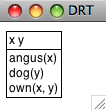

图 5.2：DRS截图

我们讨论[5.1](https://usyiyi.github.io/nlp-py-2e-zh/ch10.html#fig-drs1)中DRS的真值条件时，假设最上面的段落指称被解释为存在量词，而条件也进行了解释，虽然它们是联合的。事实上，每一个DRS都可以转化为一阶逻辑公式，`fol()`方法实现这种转换。

In [3]:
print(drs1.fol())

exists x y.(angus(x) & dog(y) & own(x,y))


作为一阶逻辑表达式功能补充，DRT`表达式`有DRS-连接运算符，用`+`符号表示。两个DRS的连接是一个单独的DRS包含合并的段落指称和来自两个论证的条件。DRS-连接自动进行α-转换绑定变量避免名称冲突。

In [4]:
drs2 = read_dexpr('([x], [walk(x)]) + ([y], [run(y)])')
print(drs2)

(([x],[walk(x)]) + ([y],[run(y)]))


In [5]:
print(drs2.simplify())

([x,y],[walk(x), run(y)])


虽然迄今为止见到的所有条件都是原子的，一个DRS可以内嵌入另一个DRS，这是全称量词被处理的方式。在`drs3`中，没有顶层的段落指称，唯一的条件是由两个子DRS组成，通过蕴含连接。再次，我们可以使用`fol()`来获得真值条件的句柄。

In [6]:
drs3 = read_dexpr('([], [(([x], [dog(x)]) -> ([y],[ankle(y), bite(x, y)]))])')
print(drs3.fol())

all x.(dog(x) -> exists y.(ankle(y) & bite(x,y)))


我们较早前指出DRT旨在通过链接照应代词和现有的段落指称来解释照应代词。DRT设置约束条件使段落指称可以像先行词那样“可访问”，但并不打算解释一个特殊的先行词如何被从候选集合中选出的。模块`nltk.sem.drt_resolve_anaphora`采用了类此的保守策略：如果DRS包含`PRO(x)`形式的条件，方法`resolve_anaphora()`将其替换为`x = [...]`形式的条件，其中`[...]`是一个可能的先行词列表。

In [7]:
drs4 = read_dexpr('([x, y], [angus(x), dog(y), own(x, y)])')
drs5 = read_dexpr('([u, z], [PRO(u), irene(z), bite(u, z)])')
drs6 = drs4 + drs5
print(drs6.simplify())

([u,x,y,z],[angus(x), dog(y), own(x,y), PRO(u), irene(z), bite(u,z)])


In [8]:
print(drs6.simplify().resolve_anaphora())

([u,x,y,z],[angus(x), dog(y), own(x,y), (u = [x,y,z]), irene(z), bite(u,z)])


由于指代消解算法已分离到它自己的模块，这有利于在替代程序中交换，使对正确的先行词的猜测更加智能。

我们对DRS的处理与处理λ-抽象的现有机制是完全兼容的，因此可以直接基于DRT而不是一阶逻辑建立组合语义表示。这种技术在下面的不确定性规则（是语法`drt.fcfg`的一部分）中说明。为便于比较，我们已经从`simple-sem.fcfg`增加了不确定性的平行规则。

> Det[num=sg,SEM=<\P Q.(([x],[]) + P(x) + Q(x))>] -> 'a'
> 
> Det[num=sg,SEM=<\P Q. exists x.(P(x) & Q(x))>] -> 'a'

## 5.2 段落处理

我们解释一句话时会使用丰富的上下文知识，一部分取决于前面的内容，一部分取决于我们的背景假设。DRT提供了一个句子的含义如何集成到前面段落表示中的理论，但是在前面的讨论中明显缺少这两个部分。首先，一直没有尝试纳入任何一种推理；第二，我们只处理了个别句子。这些遗漏由模块`nltk.inference.discourse`纠正。

段落是一个句子的序列s1, sn，段落线是读法的序列s1-ri, sn-rj ，每个序列对应段落中的一个句子。该模块按增量处理句子，当有歧义时保持追踪所有可能的线。为简单起见，下面的例子中忽略了范围歧义。

In [9]:
dt = nltk.DiscourseTester(['A student dances', 'Every student is a person'])
dt.readings()


s0 readings:

s0-r0: exists z1.(student(z1) & dance(z1))

s1 readings:

s1-r0: all z1.(student(z1) -> person(z1))


一个新句子添加到当前的段落时，设置参数`consistchk=True`会通过每条线，即每个可接受的读法的序列的检查模块来检查一致性。在这种情况下，用户可以选择收回有问题的句子。

In [16]:
dt.add_sentence('No person dances', consistchk=True)

Inconsistent discourse: d0 ['s0-r0', 's1-r0', 's2-r0']:
    s0-r0: exists z1.(student(z1) & dance(z1))
    s1-r0: all z1.(student(z1) -> person(z1))
    s2-r0: -exists z1.(person(z1) & dance(z1))



In [17]:
dt.retract_sentence('No person dances', verbose=True)

Current sentences are 
s0: A student dances
s1: Every student is a person


以类似的方式，我们使用`informchk=True`检查新的句子φ是否对当前的段落有信息量。定理证明器将段落线中现有的句子当做假设，尝试证明φ；如果没有发现这样的证据，那么它是有信息量的。

In [18]:
dt.add_sentence('A person dances', informchk=True)

Sentence 'A person dances' under reading 'exists x.(person(x) & dance(x))':
Not informative relative to thread 'd0'


也可以传递另一套假设作为背景知识，并使用这些筛选出不一致的读法；详情请参阅`http://nltk.org/howto`上的段落HOWTO。

`discourse`模块可适应语义歧义，筛选出不可接受的读法。下面的例子调用Glue语义和DRT。由于Glue语义模块被配置为使用的覆盖面广的Malt 依存关系分析器，输入（Every dog chases a boy. He runs.）需要分词和标注。

In [22]:
import nltk
from nltk.tag import RegexpTagger
tagger = RegexpTagger([
    ('^(chases|runs)$', 'VB'),
    ('^(a)$', 'ex_quant'),
    ('^(every)$', 'univ_quant'),
    ('^(dog|boy)$', 'NN'),
    ('^(He)$', 'PRP')
])
from nltk.parse import malt
mp = malt.MaltParser('D:\maltparser-1.7', 'D:\engmalt.linear-1.7.mco', tagger=tagger) # 设置环境变量或者使用文件路径，请在 asset/ 内下载相关内容
rc = nltk.DrtGlueReadingCommand(depparser=mp)
# dt = nltk.DiscourseTester(['Every dog chases a boy', 'boy runs']) # 添加自定义 tagger 无效
dt = nltk.DiscourseTester(['A dog chases the boy', 'the boy dances'])
dt.readings()


s0 readings:

s0-r0: exists z1.(dog(z1) & exists z3.(boy(z3) & chase(z1,z3) & all z2.(boy(z2) -> (z3 = z2))))

s1 readings:

s1-r0: exists z1.(boy(z1) & dance(z1) & all z2.(boy(z2) -> (z1 = z2)))


<!--
s0 readings:

s0-r0: ([],[(([x],[dog(x)]) -> ([z3],[boy(z3), chases(x,z3)]))])
s0-r1: ([z4],[boy(z4), (([x],[dog(x)]) -> ([],[chases(x,z4)]))])

s1 readings:

s1-r0: ([x],[PRO(x), runs(x)])
-->
段落的第一句有两种可能的读法，取决于量词的作用域。第二句的唯一的读法通过条件PRO(x)`表示代词He。现在让我们看看段落线的结果：

In [20]:
dt.readings(show_thread_readings=True)

d0: ['s0-r0', 's1-r0', 's2-r0'] : (exists z1.(student(z1) & dance(z1)) & all z1.(student(z1) -> person(z1)) & exists z1.(person(z1) & dance(z1)))


当我们检查段落线`d0`和`d1`时，我们看到读法`s0-r0`，其中every dog超出了`a boy`的范围，被认为是不可接受的，因为第二句的代词不能得到解释。相比之下，段落线`d1`中的代词（重写为`z24`）*通过*等式`(z24 = z20)`绑定。

不可接受的读法可以通过传递参数`filter=True`过滤掉。

In [21]:
dt.readings(show_thread_readings=True, filter=True)

d0: ['s0-r0', 's1-r0', 's2-r0'] : (exists z1.(student(z1) & dance(z1)) & all z1.(student(z1) -> person(z1)) & exists z1.(person(z1) & dance(z1)))


虽然这一小段是极其有限的，它应该能让你对于我们在超越单个句子后产生的语义处理问题，以及部署用来解决它们的技术有所了解。

## 6 小结

- 一阶逻辑是一种适合在计算环境中表示自然语言的含义的语言，因为它很灵活，足以表示自然语言含义的很多有用的方面，具有使用一阶逻辑推理的高效的定理证明器。（同样的，自然语言语义中也有各种各样的现象，需要更强大的逻辑机制。）
- 在将自然语言句子翻译成一阶逻辑的同时，我们可以通过检查一阶公式模型表述这些句子的真值条件。
- 为了构建成分组合的意思表示，我们为一阶逻辑补充了λ-演算。
- λ-演算中的β-约简在语义上与函数传递参数对应。句法上，它包括将被函数表达式中的λ绑定的变量替换为函数应用中表达式提供的参数。
- 构建模型的一个关键部分在于建立估值，为非逻辑常量分配解释。这些被解释为*n*元谓词或独立常量。
- 一个开放表达式是一个包含一个或多个自由变量的表达式。开放表达式只在它的自由变量被赋值时被解释。
- 量词的解释是对于具有变量x的公式φ[x]，构建个体的集合，赋值*g*分配它们作为x的值使φ[x]为真。然后量词对这个集合加以约束。
- 一个封闭的表达式是一个没有自由变量的表达式；也就是，变量都被绑定。一个封闭的表达式是真是假取决于所有变量赋值。
- 如果两个公式只是由绑定操作符（即λ或量词）绑定的变量的标签不同，那么它们是α-等价。重新标记公式中的绑定变量的结果被称为α-转换。
- 给定有两个嵌套量词*Q*1和*Q*2的公式，最外层的量词*Q*1有较广的范围（或范围超出*Q*2）。英语句子往往由于它们包含的量词的范围而产生歧义。
- 在基于特征的语法中英语句子可以通过将`sem`作为特征与语义表达关联。一个复杂的表达式的`sem`值通常包括成分表达式的`sem`值的函数应用。

## 7 深入阅读

关于本章的进一步材料以及如何安装Prover9定理证明器和Mace4模型生成器的内容请查阅`http://nltk.org/`。这两个推论工具一般信息见[(McCune, 2008)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#mccune)。

用NLTK进行语义分析的更多例子，请参阅`http://nltk.org/howto`上的语义和逻辑HOWTO。请注意，范围歧义还有其他两种解决方法，即[(Blackburn & Bos, 2005)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#blackburn2005rin)描述的Hole语义和[(Dalrymple, 1999)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#dalrymple:1999:rrb)描述的Glue语义。

自然语言语义中还有很多现象没有在本章中涉及到，主要有：

1. 事件、时态和体；
2. 语义角色；
3. 广义量词，如most；
4. 内涵结构，例如像may和believe这样的动词。

（1）和（2）可以使用一阶逻辑处理，（3）和（4）需要不同的逻辑。下面的读物中很多都讲述了这些问题。

建立自然语言前端数据库方面的结果和技术的综合概述可以在[(Androutsopoulos, Ritchie, & Thanisch, 1995)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#androutsopoulos1995nli)中找到。

任何一本现代逻辑的入门书都将提出命题和一阶逻辑。强烈推荐[(Hodges, 1977)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#hodges1977l)，书中有很多有关自然语言的有趣且有洞察力的文字和插图。

要说范围广泛，参阅两卷本的关于逻辑教科书[(Gamut, 1991)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#gamut1991il)和[(Gamut, 1991)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#gamut1991illg)，也包含了有关自然语言的形式语义的当代材料，例如Montague文法和内涵逻辑。[(Kamp & Reyle, 1993)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#kampreyle1993)提供段落表示理论的权威报告，包括涵盖大量且有趣的自然语言片段，包括时态、体和形态。另一个对许多自然语言结构的语义的全面研究是[(Carpenter, 1997)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#carpenter1997tls)。

有许多作品介绍语言学理论框架内的逻辑语义。[(Chierchia & McConnell-Ginet, 1990)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#chierchia1990mg)与句法相对无关，而[(Heim & Kratzer, 1998)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#heim1998sgg) and [(Larson & Segal, 1995)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#larson1995km)都更明确的倾向于将语义真值条件整合到乔姆斯基框架中。

[(Blackburn & Bos, 2005)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#blackburn2005rin)是致力于计算语义的第一本教科书，为该领域提供了极好的介绍。它扩展了许多本章涵盖的主题，包括量词范围歧义的未指定、一阶逻辑推理以及段落处理。

要获得更先进的当代语义方法的概述，包括处理时态和广义量词，尝试查阅[(Lappin, 1996)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#lappin1996hcs)或[(Benthem & Meulen, 1997)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#vanbenthem1997hll)。

## 8 练习

1. ☼ 将下列句子翻译成命题逻辑，并用`Expression.fromstring()`验证结果。提供显示你的翻译中命题变量如何对应英语表达的一个要点。

   1. If Angus sings, it is not the case that Bertie sulks.
   2. Cyril runs and barks.
   3. It will snow if it doesn't rain.
   4. It's not the case that Irene will be happy if Olive or Tofu comes.
   5. Pat didn't cough or sneeze.
   6. If you don't come if I call, I won't come if you call.

2. ☼ 翻译下面的句子为一阶逻辑的谓词参数公式。

   1. Angus likes Cyril and Irene hates Cyril.
   2. Tofu is taller than Bertie.
   3. Bruce loves himself and Pat does too.
   4. Cyril saw Bertie, but Angus didn't.
   5. Cyril is a fourlegged friend.
   6. Tofu and Olive are near each other.

3. ☼ 翻译下列句子为成一阶逻辑的量化公式。

   1. Angus likes someone and someone likes Julia.
   2. Angus loves a dog who loves him.
   3. Nobody smiles at Pat.
   4. Somebody coughs and sneezes.
   5. Nobody coughed or sneezed.
   6. Bruce loves somebody other than Bruce.
   7. Nobody other than Matthew loves somebody Pat.
   8. Cyril likes everyone except for Irene.
   9. Exactly one person is asleep.

4. ☼ 翻译下列动词短语，使用λ-抽象和一阶逻辑的量化公式。

   1. feed Cyril and give a capuccino to Angus
   2. be given 'War and Peace' by Pat
   3. be loved by everyone
   4. be loved or detested by everyone
   5. be loved by everyone and detested by no-one

5. ☼ 思考下面的语句：

   ```
   >>> read_expr = nltk.sem.Expression.fromstring
   >>> e2 = read_expr('pat')
   >>> e3 = nltk.sem.ApplicationExpression(e1, e2)
   >>> print(e3.simplify())
   exists y.love(pat, y)
   ```

   显然这里缺少了什么东西，即`e1`值的声明。为了`ApplicationExpression(e1, e2)`被β-转换为`exists y.love(pat, y)`，`e1`必须是一个以`pat`为参数的λ-抽象。你的任务是构建这样的一个抽象，将它绑定到`e1`，使上面的语句都是满足（上到字母方差）。此外，提供一个`e3.simplify()`的非正式的英文翻译。

   现在根据`e3.simplify()`的进一步情况（如下所示）继续做同样的任务。

   ```
   >>> print(e3.simplify())
   exists y.(love(pat,y) | love(y,pat))
   ```

   ```
   >>> print(e3.simplify())
   exists y.(love(pat,y) | love(y,pat))
   ```

   ```
   >>> print(e3.simplify())
   walk(fido)
   ```

6. ☼ 如前面的练习中那样，找到一个λ-抽象`e1`，产生与下面显示的等效的结果。

   ```
   >>> e2 = read_expr('chase')
   >>> e3 = nltk.sem.ApplicationExpression(e1, e2)
   >>> print(e3.simplify())
   \x.all y.(dog(y) -> chase(x,pat))
   ```

   ```
   >>> e2 = read_expr('chase')
   >>> e3 = nltk.sem.ApplicationExpression(e1, e2)
   >>> print(e3.simplify())
   \x.exists y.(dog(y) & chase(pat,x))
   ```

   ```
   >>> e2 = read_expr('give')
   >>> e3 = nltk.sem.ApplicationExpression(e1, e2)
   >>> print(e3.simplify())
   \x0 x1.exists y.(present(y) & give(x1,y,x0))
   ```

7. ☼ 如前面的练习中那样，找到一个λ-抽象`e1`，产生与下面显示的等效的结果。

   ```
   >>> e2 = read_expr('bark')
   >>> e3 = nltk.sem.ApplicationExpression(e1, e2)
   >>> print(e3.simplify())
   exists y.(dog(x) & bark(x))
   ```

   ```
   >>> e2 = read_expr('bark')
   >>> e3 = nltk.sem.ApplicationExpression(e1, e2)
   >>> print(e3.simplify())
   bark(fido)
   ```

   ```
   >>> e2 = read_expr('\\P. all x. (dog(x) -> P(x))')
   >>> e3 = nltk.sem.ApplicationExpression(e1, e2)
   >>> print(e3.simplify())
   all x.(dog(x) -> bark(x))
   ```

8. ◑ 开发一种方法，翻译英语句子为带有二元广义量词的公式。在此方法中，给定广义量词`Q`，量化公式的形式为`Q(A, B)`，其中`A`和`B`是〈*e*, *t*〉类型的表达式。那么，例如`all(A, B)`为真当且仅当`A`表示的是`B`所表示的一个子集。

9. ◑ 扩展前面练习中的方法，使量词如most和exactly three的真值条件可以在模型中计算。

10. ◑ 修改`sem.evaluate`代码，使它能提供一个有用的错误消息，如果一个表达式不在模型的估值函数的域中。

11. ★ 从儿童读物中选择三个或四个连续的句子。一个例子是`nltk.corpus.gutenberg`中的故事集：`bryant-stories.txt`，`burgess-busterbrown.txt`和`edgeworth-parents.txt`。开发一个语法，能将你的句子翻译成一阶逻辑，建立一个模型，使它能检查这些翻译为真或为假。

12. ★ 实施前面的练习，但使用DRT作为意思表示。

13. ★ 以[(Warren & Pereira, 1982)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#warren1982eea)为出发点，开发一种技术，转换一个自然语言查询为一种可以更加有效的在模型中评估的形式。例如，给定一个`(P(x) & Q(x))`形式的查询，将它转换为`(Q(x) & P(x))`，如果`Q`的范围比`P`小。

关于本文档...

针对NLTK 3.0 作出更新。本章来自于*Natural Language Processing with Python*，[Steven Bird](http://estive.net/), [Ewan Klein](http://homepages.inf.ed.ac.uk/ewan/) 和[Edward Loper](http://ed.loper.org/)，Copyright © 2014 作者所有。本章依据*Creative Commons Attribution-Noncommercial-No Derivative Works 3.0 United States License* [http://creativecommons.org/licenses/by-nc-nd/3.0/us/] 条款，与*自然语言工具包* [`http://nltk.org/`] 3.0 版一起发行。

本文档构建于星期三 2015 年 7 月 1 日 12:30:05 AEST